<a href="https://colab.research.google.com/github/Ragdehl/Rakuten_py/blob/main/manu/PICTURES_DEEP_LEARNING_18th_JULY_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob
import os

In [ ]:
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
X = pd.read_csv('X_train_update.csv',index_col=0)
y = pd.read_csv('Y_train_CVw08PX.csv',index_col=0)

In [ ]:
current_path = os.getcwd() 
images_path = current_path + r'/images2/image_train/'
images_list = os.listdir(images_path)

In [ ]:
X['image name'] = 'image_' + X['imageid'].map(str) + '_product_' + X['productid'].map(str) + '.jpg'

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 123)
X_val = X_train.iloc[:8400,:]
y_val = y_train.iloc[:8400,:]
X_train = X_train.iloc[:84000,:]
y_train = y_train.iloc[:84000:,:]
X_test = X_test.iloc[:13800,:]
y_test = y_test.iloc[:13800,:]

X_train["class"] = y_train
X_test["class"] = y_test
X_val["class"] = y_val

In [ ]:
train_data_generator = ImageDataGenerator(rescale = 1./255, rotation_range = 10, width_shift_range = 0.15, height_shift_range = 0.15,zoom_range = 1.1, horizontal_flip = True)
val_data_generator = ImageDataGenerator(rescale = 1./255, rotation_range = 10, width_shift_range = 0.15, height_shift_range = 0.15,zoom_range = 1.1,horizontal_flip = True)
test_data_generator = ImageDataGenerator(rescale = 1./255)

In [ ]:
batch_size = 64
path = images_path
X_train["class"] = X_train["class"].astype(str)
X_test["class"] = X_test["class"].astype(str)
X_val["class"] = X_val["class"].astype(str)

train_generator = train_data_generator.flow_from_dataframe(dataframe=X_train, directory=path, x_col = "image name", y_col = "class",
class_mode ="sparse", target_size = (240, 240), batch_size = batch_size)

val_generator = val_data_generator.flow_from_dataframe(dataframe=X_val, directory=path, x_col = "image name", y_col = "class",
class_mode ="sparse", target_size = (240, 240), batch_size = batch_size)

test_generator = test_data_generator.flow_from_dataframe(dataframe=X_test, directory=path, x_col = "image name", y_col = "class",
class_mode ="sparse", target_size = (240, 240), batch_size = batch_size)

Found 61138 validated image filenames belonging to 27 classes.
Found 8400 validated image filenames belonging to 27 classes.
Found 13800 validated image filenames belonging to 27 classes.


In [ ]:
import sys
import os
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dropout,Dense, Flatten, GlobalAveragePooling2D
from keras.layers import *
from keras.optimizers import *
from keras.applications import *
from keras.applications.xception import Xception, preprocess_input
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as k
from tensorflow.keras.optimizers import RMSprop
from keras import layers

In [ ]:
import keras.applications as kapps

In [ ]:
from keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
opt = Adam(lr=0.0001)

C:\Users\utilisateur\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [ ]:
#inputshape = (150, 150, 3)
#pprocfunc = kapps.xception.preprocess_input
basemodel = kapps.xception.Xception( input_shape = (240, 240, 3) ,include_top = False, weights = 'imagenet')
# Freezer les couches
basemodel = basemodel
for layer in basemodel.layers:
    layer.trainable = False 
    
# ou base_model.trainable = False

In [ ]:
basemodel.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 240, 240, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 119, 119, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 119, 119, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 119, 119, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [ ]:
x = layers.Flatten()(basemodel.output)
x = layers.Dense(1024, activation='relu')(x)
x = Dropout(0.35)(x)
#x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = layers.Dropout(0.30)(x)
#x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(27, activation='softmax')(x)

model = tf.keras.models.Model(basemodel.input, x)
model.compile(optimizer = opt, loss = 'sparse_categorical_crossentropy', metrics = ['acc'])

In [ ]:
# implementation du callback checkpoint
# Callback to save the Keras model or model weights at some frequency.
from tensorflow.keras import callbacks
import os
cwd = os.getcwd()
filepath = cwd
checkpoint = callbacks.ModelCheckpoint(filepath = filepath, monitor = 'val_loss', save_best_only = True, save_weights_only = False,
                                       mode = 'min', save_freq = 'epoch')

In [ ]:
lr_plateau = callbacks.ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=2, mode='min')

In [ ]:
epoch = 2

test_history = model.fit(train_generator, epochs = epoch,steps_per_epoch = len(X_train)//batch_size, validation_data = val_generator,
                        validation_steps = len(X_val)//batch_size) #, callbacks = [lr_plateau , checkpoint])

Epoch 1/2
955/955 [==============================] - 2921s 3s/step - loss: 2.3002 - acc: 0.3480 - val_loss: 2.0974 - val_acc: 0.3900
Epoch 2/2
955/955 [==============================] - 2920s 3s/step - loss: 2.0649 - acc: 0.3958 - val_loss: 1.9998 - val_acc: 0.4095


In [ ]:
for layer in base_model.layers[-5:]:
    layer.trainable = True

In [ ]:
model.compile(optimizer= opt , loss='sparse_categorical_crossentropy', metrics = ['accuracy'])
hist_unfreeze = model.fit(train_generator, epochs = 3, steps_per_epoch = len(X_train)//batch_size, validation_data=test_generator,
                                validation_steps=len(X_val)//batch_size)

Epoch 1/3
955/955 [==============================] - 2940s 3s/step - loss: 2.0181 - accuracy: 0.4055 - val_loss: 1.5805 - val_accuracy: 0.5268
Epoch 2/3
955/955 [==============================] - 2844s 3s/step - loss: 1.9776 - accuracy: 0.4153 - val_loss: 1.5672 - val_accuracy: 0.5370
Epoch 3/3
955/955 [==============================] - 2836s 3s/step - loss: 1.9402 - accuracy: 0.4263 - val_loss: 1.5398 - val_accuracy: 0.5397


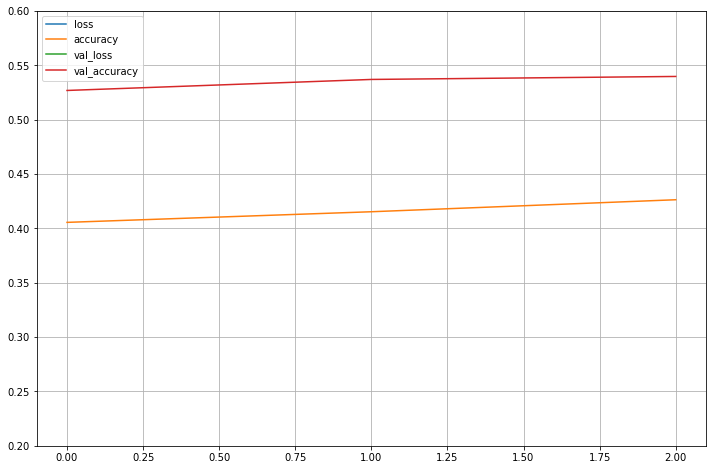

In [ ]:
import pandas as pd
pd.DataFrame(hist_unfreeze.history).plot(figsize=(12, 8))
plt.grid(True)
plt.gca().set_ylim(0.2, 0.6) # set the vertical range to [0-1]
plt.show()

In [ ]:
# TEST COMPLEMENTAIRE EN AJUSTANT LA FN ACTIVATION

In [ ]:
x = layers.Flatten()(basemodel.output)
x = layers.Dense(1024, activation='swish')(x)
x = Dropout(0.35)(x)
#x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='swish')(x)
x = layers.Dropout(0.30)(x)
#x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='swish')(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(27, activation='softmax')(x)

model = tf.keras.models.Model(basemodel.input, x)
model.compile(optimizer = opt, loss = 'sparse_categorical_crossentropy', metrics = ['acc'])

In [ ]:
epoch = 3

test_history2 = model.fit(train_generator, epochs = epoch,steps_per_epoch = len(X_train)//batch_size, validation_data = val_generator,
                        validation_steps = len(X_val)//batch_size) #, callbacks = [lr_plateau , checkpoint])

Epoch 1/3
955/955 [==============================] - 2806s 3s/step - loss: 2.4399 - acc: 0.3421 - val_loss: 2.0807 - val_acc: 0.3897
Epoch 2/3
955/955 [==============================] - 2788s 3s/step - loss: 2.0750 - acc: 0.3920 - val_loss: 2.0105 - val_acc: 0.4123
Epoch 3/3
955/955 [==============================] - 2814s 3s/step - loss: 2.0149 - acc: 0.4072 - val_loss: 1.9598 - val_acc: 0.4221


In [ ]:
for layer in basemodel.layers[-4:]:
    layer.trainable = True

In [ ]:
model.compile(optimizer= opt , loss='sparse_categorical_crossentropy', metrics = ['accuracy'])
hist_unfreeze = model.fit(train_generator, epochs = 4, steps_per_epoch = len(X_train)//batch_size, validation_data=test_generator,
                                validation_steps=len(X_val)//batch_size)

Epoch 1/4
955/955 [==============================] - 3393s 4s/step - loss: 1.9798 - accuracy: 0.4182 - val_loss: 1.5019 - val_accuracy: 0.5471
Epoch 2/4
955/955 [==============================] - 3376s 4s/step - loss: 1.8844 - accuracy: 0.4441 - val_loss: 1.4675 - val_accuracy: 0.5581
Epoch 3/4
955/955 [==============================] - 3328s 3s/step - loss: 1.8367 - accuracy: 0.4559 - val_loss: 1.4140 - val_accuracy: 0.5772
Epoch 4/4
955/955 [==============================] - 3397s 4s/step - loss: 1.7918 - accuracy: 0.4668 - val_loss: 1.3895 - val_accuracy: 0.5847


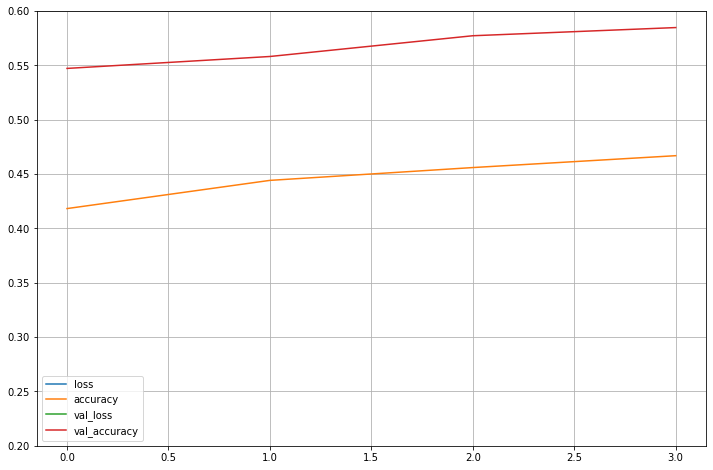

In [ ]:
import pandas as pd
pd.DataFrame(hist_unfreeze.history).plot(figsize=(12, 8))
plt.grid(True)
plt.gca().set_ylim(0.2, 0.6) # set the vertical range to [0-1]
plt.show()